###  Visualize outputs after finishing with the pipelines

In [344]:
import pandas as pd
import scanpy as sc
import os
from os import walk
import pandas as pd
from os.path import join
from matplotlib import rcParams
%matplotlib inline

### Plotting functions hidden

In [405]:
def get_metrics(metrics_dir='../scIB_run/retinal/metrics'):
    metrics_by_k = {}
    for root_dir in [metrics_dir]:
        dk = root_dir.split('/')[-1]
        # print(dk)
        for (d, dirnames, filenames) in os.walk(root_dir):    
            for f in filenames:
                p = join(d, f)
                if not f.endswith('.csv'):
                    continue
                scaling_lab, gene_feat_lab = d.split('/')[-2:]
                gene_feat_lab = gene_feat_lab.replace('full_feature', 'full')

                method = f.replace('.csv', '')
                k = "_".join([method, scaling_lab, gene_feat_lab])
                # print(k, p)
                try:
                    df = pd.read_csv(p, index_col=0)
                    df['method'] = k
                    df.columns = ['score', 'method']
                    metrics_by_k[k] = df

                except:
                    print('error while loading', p)
    return metrics_by_k

def get_adata_by_k(method, scaling, hvg):
    ad_by_k = {}
    
    path = join(integration_dir, scaling, hvg, method + '.h5ad')
    print(exists(path), path)
    
    k = "_".join([method, scaling, hvg])
    
    print(k, path)
    
    if not exists(path):
        ad_by_k[k] = None
        return ad_by_k
    try:
        print('loading...')
        ad_by_k[k] = sc.read(path)
        print('done...')
    except Exception as err:
        print(err)
    
    return ad_by_k

def plot_metrics_clustermap(res):
    hm = res.reset_index().pivot('method', 'index', 'score')
    hm.index = hm.index.str.replace('_full_', '_F_')
    hm.index = hm.index.str.replace('unscaled', 'S(-)').str.replace('_scaled', '_S(+)').str.replace('_full', '_H(-)').str.replace('hvg', 'H(+)')
    hm.index = hm.index.str.replace('_F_', '_full_')
    hm = hm.fillna(0)
    rank = hm.mean(axis=1).rank(ascending=False)
    colors = ["#f7fcf5", "#e5f5e0", "#c7e9c0", "#a1d99b", "#74c476",
              "#41ab5d", "#238b45", "#006d2c", "#00441b"][::-1]

    rank_values = rank.values
    rank = [colors[min(int(ri) - 1, len(colors) - 1)] for ri in rank_values]

    row_colors = pd.DataFrame(index=hm.index)

    row_colors['mode'] = hm.index.str.split('_').str[1].map({'knn': '#8dd3c7', 'embed': '#ffffb3', 'full': '#bebada'})
    row_colors['hvg'] = np.where(hm.index.str.contains('_H(+)', regex=0), 'gray', 'white')
    row_colors['scaled'] = np.where(hm.index.str.contains('_S(+)', regex=0), 'gray', 'white')
    row_colors['rank'] = rank

    hm.index = hm.index.str.split("_").str[0]
    row_colors.index = hm.index

    sns.set(font_scale=.8)
    g = sns.clustermap(hm, cmap='Reds', row_colors=row_colors, yticklabels=True, xticklabels=True,
                       figsize=[6, 6.5], cbar_pos=(0.05, 0.85, 0.02, 0.10), colors_ratio=.03, dendrogram_ratio=.2)
    g.cax.set_title("score")

def plot_umaps(ad_by_k, save=True):
    for ki, k in enumerate(ad_by_k):
        ad = ad_by_k[k]
        
        print(k, ad)
        if ad is None:
            continue
        
        output_path = join('../scIB_run/figures/%s.png' % k)
        if save and exists(output_path):
            print('skip %s' % k)
            continue

        print('next %s' % k)

        if not k in processed_by_k:
            if 'X_emb' in ad.obsm:
                print('neighbors...')
                sc.pp.neighbors(ad, use_rep='X_emb')
                sc.tl.umap(ad)
                print('umap...')
                if not 'cell.type' in ad.obs:
                    ad.obs['cell.type'] = ad.obs.index.map(cell_type_by_k)
            else:
                sc.pp.neighbors(ad, use_rep='X')
                sc.tl.umap(ad)
            processed_by_k[k] = ad
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 5))
        ad = processed_by_k[k]
        if 'X_emb' in ad.obsm:
            sc.pl.umap(ad, color='study' if 'study' in ad.obs else 'batch', title=k, ax=ax[0], show=False)
            sc.pl.umap(ad, color='cell.type', title=k, ax=ax[1], show=False)
        else:
            sc.pl.umap(ad, color='cell.type', title=k, ax=ax[0], show=False)
            sc.pl.umap(ad, color='study', title=k, ax=ax[1], show=False)

        if save:
            plt.savefig(output_path)
            plt.close()
    

In [270]:
from matplotlib import rcParams
def set_figsize(w, h):
    rcParams['figure.figsize'] = w, h
def set_figdpi(dpi):
    rcParams['figure.dpi'] = dpi


In [382]:
len(set(res['method'].str.split('_').str[0]))

13

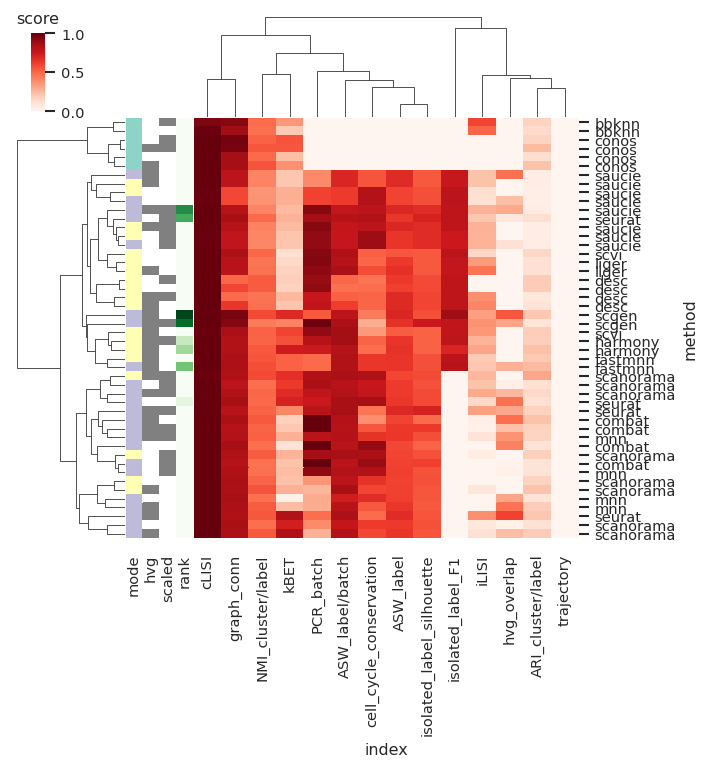

In [346]:
set_figdpi(120)
metrics_by_k = get_metrics()
res = pd.concat([metrics_by_k[k] for k in metrics_by_k])

plot_metrics_clustermap(res)


In [350]:
# Top 10 by mean
res.groupby('method').mean().sort_values('score', ascending=False).head(5)

,score
method,
scgen_full_unscaled_hvg,0.637405
harmony_embed_unscaled_hvg,0.635182
harmony_embed_scaled_hvg,0.630087
saucie_embed_scaled_hvg,0.625704
scvi_embed_unscaled_hvg,0.625693


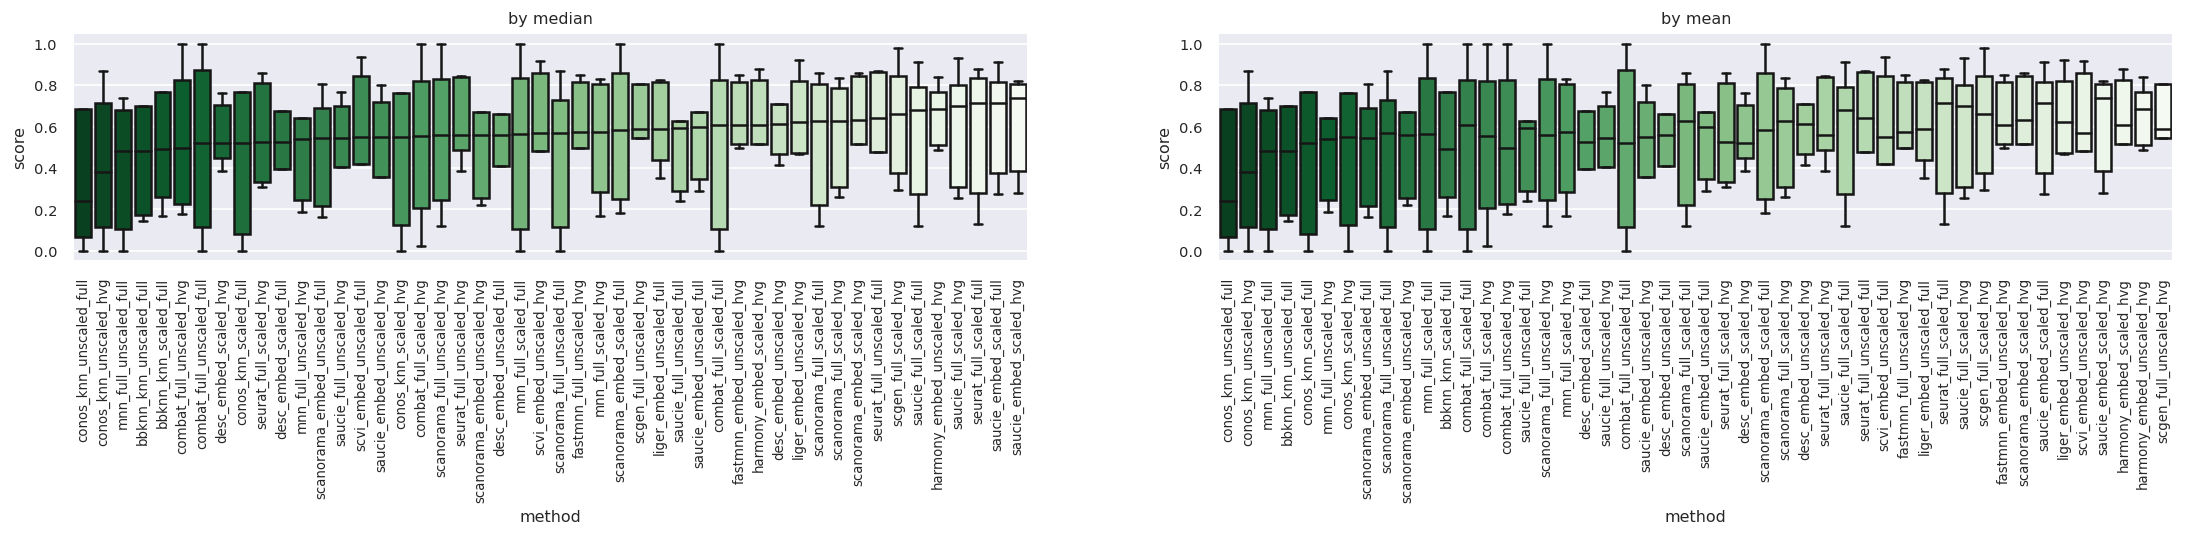

In [351]:
plt.subplot(1, 2, 1)
set_figsize(20, 5)
plt.title('by median')
sns.boxplot(y='score', x='method', data=res, order=res.groupby('method').median().sort_values('score').index,
            showfliers=False, palette='Greens_r', whis=.3)
plt.xticks(rotation=90, fontsize=8)
plt.subplots_adjust(bottom=.5, right=1.0)

plt.subplot(1, 2, 2)
sns.boxplot(y='score', x='method', data=res, order=res.groupby('method').mean().sort_values('score').index,
            showfliers=False, palette='Greens_r', whis=.3)
plt.title('by mean')
plt.xticks(rotation=90, fontsize=8)
plt.subplots_adjust(bottom=.5,  right=1.0,)


In [349]:
prepare_dir = '../scIB_run/retinal/prepare'
integration_dir = '../scIB_run/retinal/integration'

In [359]:
kq

'integration_scvi_unscaled_hvg'

In [406]:
ad_by_k = {}
for ki, k in res.groupby('method').mean().sort_values('score', ascending=False).head(5).iterrows():
    
    print(ki)    
    method = ki.split('_')[0]
    representation = ki.split('_')[1]
    scaling = ki.split('_')[2]
    hvg = ki.split('_')[-1].replace('full', 'full_feature')
    
    print(method, scaling, hvg)
    ad_by_k = {**ad_by_k, **get_adata_by_k(method, scaling, hvg)}
    print(ad_by_k.keys())
    continue
    

###  cell types by index barcode value
for k in ad_by_k:
    ad = ad_by_k[k]
    if ad is None:
        continue
    if 'cell.type' in ad.obs:
        cell_type_by_k = pd.Series(ad.obs['cell.type'], index=ad.obs.index).to_dict()



scgen_full_unscaled_hvg
scgen unscaled hvg
False ../scIB_run/retinal/integration/unscaled/hvg/scgen.h5ad
scgen_unscaled_hvg ../scIB_run/retinal/integration/unscaled/hvg/scgen.h5ad
dict_keys(['scgen_unscaled_hvg'])
harmony_embed_unscaled_hvg
harmony unscaled hvg
False ../scIB_run/retinal/integration/unscaled/hvg/harmony.h5ad
harmony_unscaled_hvg ../scIB_run/retinal/integration/unscaled/hvg/harmony.h5ad
dict_keys(['scgen_unscaled_hvg', 'harmony_unscaled_hvg'])
harmony_embed_scaled_hvg
harmony scaled hvg
False ../scIB_run/retinal/integration/scaled/hvg/harmony.h5ad
harmony_scaled_hvg ../scIB_run/retinal/integration/scaled/hvg/harmony.h5ad
dict_keys(['scgen_unscaled_hvg', 'harmony_unscaled_hvg', 'harmony_scaled_hvg'])
saucie_embed_scaled_hvg
saucie scaled hvg
True ../scIB_run/retinal/integration/scaled/hvg/saucie.h5ad
saucie_scaled_hvg ../scIB_run/retinal/integration/scaled/hvg/saucie.h5ad
loading...
done...
dict_keys(['scgen_unscaled_hvg', 'harmony_unscaled_hvg', 'harmony_scaled_hvg', 'sa

In [407]:
ad_by_k.keys()

dict_keys(['scgen_unscaled_hvg', 'harmony_unscaled_hvg', 'harmony_scaled_hvg', 'saucie_scaled_hvg', 'scvi_unscaled_hvg'])

In [408]:
processed_by_k = {}

In [409]:
sns.reset_orig()

scgen_unscaled_hvg None
harmony_unscaled_hvg None
harmony_scaled_hvg None
saucie_scaled_hvg AnnData object with n_obs × n_vars = 32822 × 2000
    obs: 'batch', 'cell.type', 'leiden', 'n_counts', 'study', 'tech'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_emb', 'X_pca', 'X_umap'
    layers: 'counts'
next saucie_scaled_hvg
neighbors...
umap...
scvi_unscaled_hvg AnnData object with n_obs × n_vars = 32822 × 2000
    obs: 'cell.type', 'tech', 'study', 'n_counts', 'leiden', 'batch'
    var: 'gene_ids-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-0-0-0-0-0-0-0-0-0-0-0', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_emb', 'X_pca', 'X_umap'
    layers: 'counts'
next scvi_unscaled_hvg
neighbors...
umap...


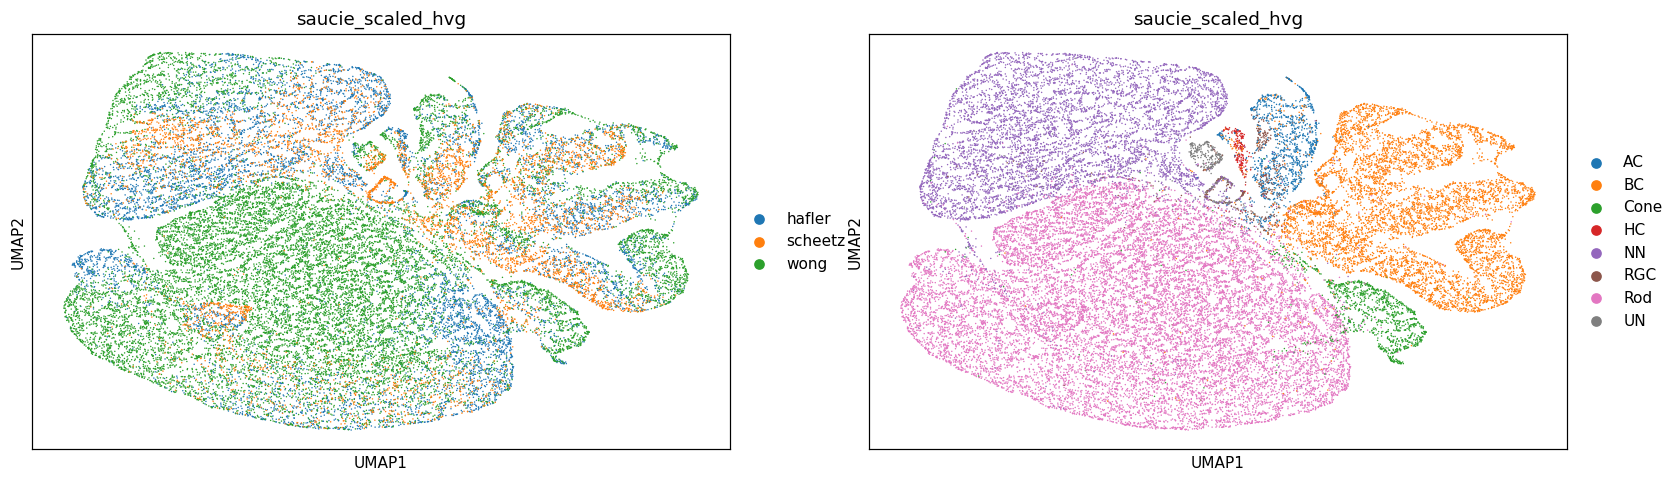

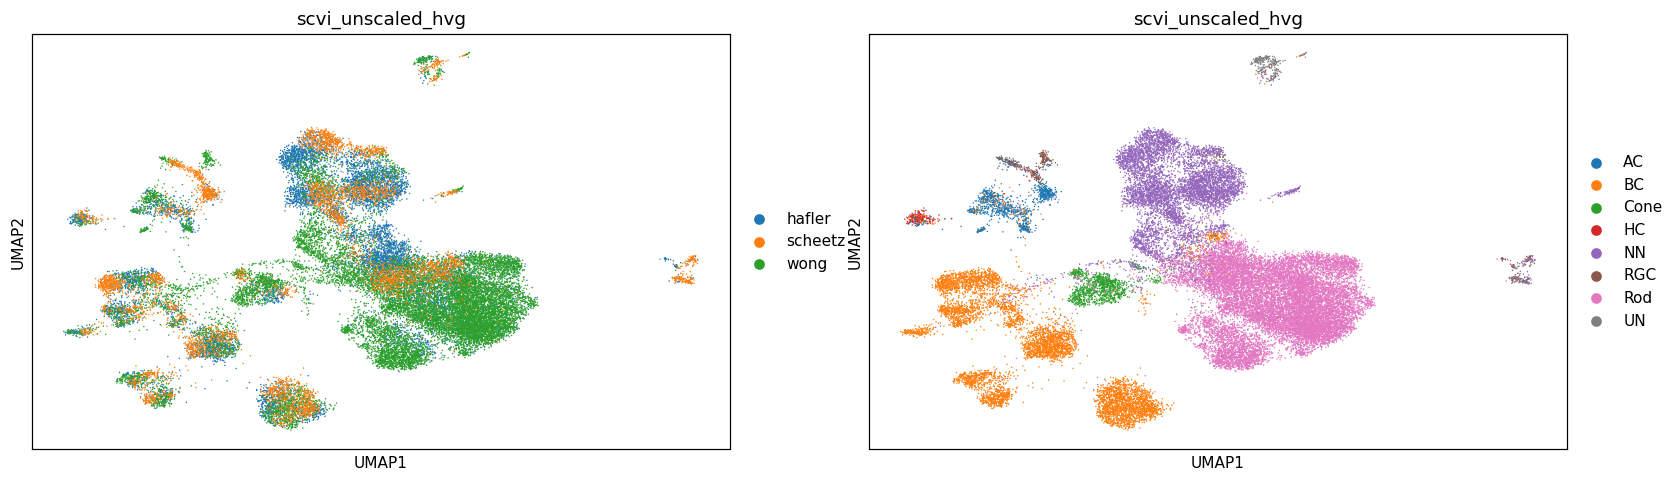

In [410]:
set_figsize(6, 6)
set_figdpi(110)
plot_umaps(ad_by_k, save=False)

### Save scgen h5ad for other purposes (cell identity TFs, DE-genes, etc.)

<AxesSubplot:title={'center':'scgen_unscaled_hvg'}, xlabel='UMAP1', ylabel='UMAP2'>

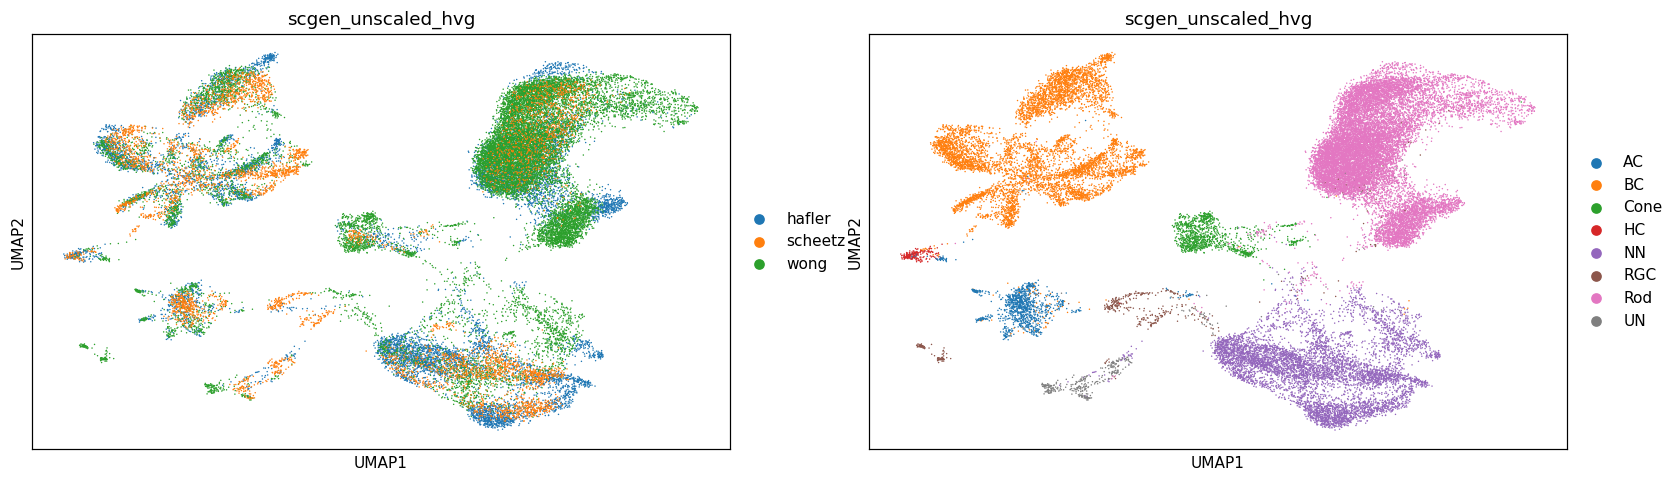

In [414]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18, 5))
ad = adata
sc.pl.umap(ad, color='study', title='scgen_unscaled_hvg', ax=ax[0], show=False)
sc.pl.umap(ad, color='cell.type', title='scgen_unscaled_hvg', ax=ax[1], show=False)


In [327]:
k = 'integration_scgen_unscaled_hvg'
adata = processed_by_k[k].copy()

adata.obs['cell.id'] = adata.obs.index
adata.obs_names = np.arange(adata.shape[0])
adata.write('../data/integrated/%s.h5ad' % k, compression='lzf')

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
